# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig0831s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 400

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1018, 32, 20, 3)
(1018, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Epoch 1/400


C:\Users\Muell\anaconda3\envs\py38-tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


255/255 [==============================] - 2s 5ms/step - loss: 2.1382 - accuracy: 0.3646
Epoch 2/400
255/255 [==============================] - 1s 5ms/step - loss: 1.3682 - accuracy: 0.5819
Epoch 3/400
255/255 [==============================] - 1s 4ms/step - loss: 0.9758 - accuracy: 0.6899
Epoch 4/400
255/255 [==============================] - 1s 5ms/step - loss: 0.6623 - accuracy: 0.7996
Epoch 5/400
255/255 [==============================] - 1s 5ms/step - loss: 0.6526 - accuracy: 0.7946
Epoch 6/400
255/255 [==============================] - 1s 5ms/step - loss: 0.5549 - accuracy: 0.8308
Epoch 7/400
255/255 [==============================] - 1s 5ms/step - loss: 0.5982 - accuracy: 0.8243
Epoch 8/400
255/255 [==============================] - 1s 5ms/step - loss: 0.4056 - accuracy: 0.8682
Epoch 9/400
255/255 [==============================] - 1s 6ms/step - loss: 0.3775 - accuracy: 0.8781
Epoch 10/400
255/255 [==============================] - 2s 6ms/step - loss: 0.3517 - accuracy: 0.8889
E

255/255 [==============================] - 3s 11ms/step - loss: 0.0864 - accuracy: 0.9702
Epoch 81/400
255/255 [==============================] - 3s 10ms/step - loss: 0.1000 - accuracy: 0.9668
Epoch 82/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0856 - accuracy: 0.9735
Epoch 83/400
255/255 [==============================] - 3s 11ms/step - loss: 0.0445 - accuracy: 0.9880
Epoch 84/400
255/255 [==============================] - 3s 11ms/step - loss: 0.0709 - accuracy: 0.9842
Epoch 85/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0621 - accuracy: 0.9873
Epoch 86/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0628 - accuracy: 0.9771
Epoch 87/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0728 - accuracy: 0.9801
Epoch 88/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0542 - accuracy: 0.9909 0s - loss: 0.0519 - 
Epoch 89/400
255/255 [==============================] - 3s 10ms/s

255/255 [==============================] - 3s 10ms/step - loss: 0.0521 - accuracy: 0.9864
Epoch 159/400
255/255 [==============================] - 3s 11ms/step - loss: 0.0645 - accuracy: 0.9900
Epoch 160/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0229 - accuracy: 0.9910
Epoch 161/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0435 - accuracy: 0.9909
Epoch 162/400
255/255 [==============================] - 3s 11ms/step - loss: 0.0741 - accuracy: 0.9841
Epoch 163/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0236 - accuracy: 0.9874
Epoch 164/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0284 - accuracy: 0.9904
Epoch 165/400
255/255 [==============================] - 3s 10ms/step - loss: 0.1147 - accuracy: 0.9841
Epoch 166/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0684 - accuracy: 0.9875
Epoch 167/400
255/255 [==============================] - 3s 10ms/step - loss: 

255/255 [==============================] - 3s 10ms/step - loss: 0.0055 - accuracy: 0.9988
Epoch 237/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0488 - accuracy: 0.9909
Epoch 238/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0062 - accuracy: 0.9972
Epoch 239/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0195 - accuracy: 0.9971
Epoch 240/400
255/255 [==============================] - 3s 11ms/step - loss: 0.0245 - accuracy: 0.9960
Epoch 241/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0417 - accuracy: 0.9958
Epoch 242/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0167 - accuracy: 0.9962
Epoch 243/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0429 - accuracy: 0.9879
Epoch 244/400
255/255 [==============================] - 3s 11ms/step - loss: 0.0384 - accuracy: 0.9929
Epoch 245/400
255/255 [==============================] - 3s 10ms/step - loss: 

255/255 [==============================] - 3s 11ms/step - loss: 0.0346 - accuracy: 0.9928
Epoch 314/400
255/255 [==============================] - 3s 11ms/step - loss: 0.0378 - accuracy: 0.9941
Epoch 315/400
255/255 [==============================] - 3s 11ms/step - loss: 0.0114 - accuracy: 0.9938
Epoch 316/400
255/255 [==============================] - 3s 11ms/step - loss: 0.0074 - accuracy: 0.9951
Epoch 317/400
255/255 [==============================] - 3s 11ms/step - loss: 0.0225 - accuracy: 0.9954 0s
Epoch 318/400
255/255 [==============================] - 3s 11ms/step - loss: 0.0106 - accuracy: 0.9950
Epoch 319/400
255/255 [==============================] - 3s 10ms/step - loss: 0.0181 - accuracy: 0.9955
Epoch 320/400
255/255 [==============================] - 3s 11ms/step - loss: 0.0516 - accuracy: 0.9923
Epoch 321/400
255/255 [==============================] - 3s 11ms/step - loss: 0.0150 - accuracy: 0.9947
Epoch 322/400
255/255 [==============================] - 3s 11ms/step - los

255/255 [==============================] - 2s 8ms/step - loss: 0.0259 - accuracy: 0.9939
Epoch 392/400
255/255 [==============================] - 2s 7ms/step - loss: 0.0299 - accuracy: 0.9962
Epoch 393/400
255/255 [==============================] - 2s 7ms/step - loss: 0.0288 - accuracy: 0.9947
Epoch 394/400
255/255 [==============================] - 2s 8ms/step - loss: 0.0061 - accuracy: 0.9998
Epoch 395/400
255/255 [==============================] - 2s 8ms/step - loss: 0.0305 - accuracy: 0.9920
Epoch 396/400
255/255 [==============================] - 2s 7ms/step - loss: 0.0156 - accuracy: 0.9964
Epoch 397/400
255/255 [==============================] - 2s 7ms/step - loss: 0.0299 - accuracy: 0.9906
Epoch 398/400
255/255 [==============================] - 2s 8ms/step - loss: 0.0060 - accuracy: 0.9984
Epoch 399/400
255/255 [==============================] - 2s 7ms/step - loss: 0.0190 - accuracy: 0.9947
Epoch 400/400
255/255 [==============================] - 2s 7ms/step - loss: 0.0382 - a

### Learing result
 
* Visualization of the training and validation results

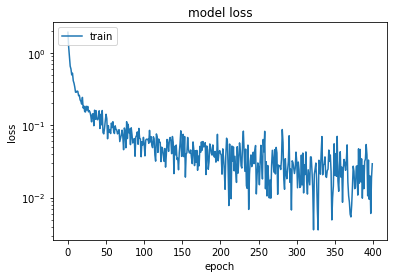

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

C:\Users\Muell\anaconda3\envs\py38-tf24\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


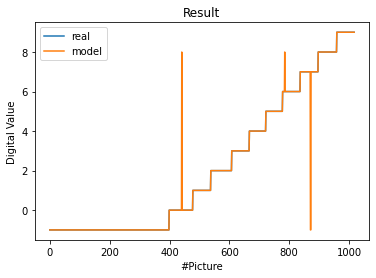

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpyov0_i38\assets


766432

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpb17z2jtg\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpb17z2jtg\assets


203200

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = model.predict_classes(img)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


C:\Users\Muell\anaconda3\envs\py38-tf24\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ziffer_sortiert_resize/0\D6_2020-08-16_01-02-52.jpg 0 8
ziffer_sortiert_resize/6\20200815-182914_digit3.jpg 6 8
ziffer_sortiert_resize/7\D6_2020-08-14_15-13-16.jpg 7 NaN
ziffer_sortiert_resize/7\D6_2020-08-19_21-15-56.jpg 7 NaN


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.